In [22]:
% matplotlib inline
from gensim.models.ldamodel import LdaModel
import gensim
import pandas as pd
import glob
from nltk.corpus import stopwords
import string
from gensim import corpora
import timeit
from collections import defaultdict
from nltk import PorterStemmer
from gensim.utils import lemmatize # Only keep nums
import re
from bs4 import BeautifulSoup
import urllib
import time
import threading
import sqlite3

In [3]:
import os
os.chdir("C:\\Users\\Miya\\OneDrive\\Miya'sGithub\\NLP-for-CNY-Trending\\datasets")

In [5]:
df_all = pd.DataFrame()
for i in glob.glob('*[0-9].csv'):
    df = pd.read_csv(i)
    df_all = pd.concat([df,df_all],ignore_index=True)

In [7]:
print(len(df_all))

2466


In [8]:
df_all['date'] = pd.to_datetime(df_all['date'])
df_all['YearMonth'] = df_all['date'].map(lambda x: str(x.year) + '-'+str(x.month))
df_all['YearMonth']  = pd.to_datetime(df_all['YearMonth'])

In [15]:
url_list = df_all['url']

In [19]:
url_list[0]

'http://www.nytimes.com/2015/01/01/world/asia/chinese-court-orders-6-companies-to-pay-26-million-for-polluting.html'

In [44]:
import http.cookiejar, urllib.request
cj = http.cookiejar.CookieJar()
opener = urllib.request.build_opener(urllib.request.HTTPCookieProcessor(cj))
r = opener.open(url_list[0])
soup = BeautifulSoup(r)
article = soup.findAll('p',"story-body-text story-content")
list_a = [i.text for i in article]

C:\Users\Miya\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file C:\Users\Miya\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [63]:
start_time = time.clock()
whole_article = []
for url in url_list:
    r = opener.open(url_list[0])
    soup = BeautifulSoup(r)
    article = soup.findAll('p',"story-body-text story-content")
    list_a = [i.text for i in article]
    whole_article +=['\n'.join(list_a)] 
time.clock()-start_time

C:\Users\Miya\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file C:\Users\Miya\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


2887.306755710158

In [64]:
df_all['whole_article'] = whole_article

In [65]:
df_all.to_csv('df-all.csv')

In [7]:
df_all = pd.read_csv('df-all.csv',encoding = 'iso-8859-1')

In [11]:
del df_all['Unnamed: 0']

In [20]:
df_all.values[0][0]

'Chinese provincial court upholds lower court verdict imposing fines totaling around $26 million on six companies convicted of dumping waste acid into water; pollution is growing concern in China and environmental protection laws are becoming stronger.'

In [17]:
execute_query = "INSERT table NYTIMES" +'(' + ",".join(df_all.columns) + ')' +  'values'+'('+'?'*len(df_all.columns)+ ')'
execute_query

'INSERT table NYTIMES(abstract,date,desk,headline,id,lead_paragraph,locations,section,source,subjects,type,url,word_count,YearMonth,whole_article)values(???????????????)'

In [50]:
from sqlite3 import OperationalError
conn = sqlite3.connect("NYTimes.db")

cur = conn.cursor()

init_query = "create table NYTIMES" + '(' + ",".join(df_all.columns) + ')'
try:
    cur.execute(init_query)
except OperationalError:
    print("database already there!")

execute_query = ("INSERT INTO NYTIMES" +' (' + ",".join(df_all.columns) + ')' +  
                 ' values '+'('+'?,'*(len(df_all.columns)-1) +'?'+')')

database already there!


In [56]:
for i in df_all.values:
    cur.execute(execute_query,tuple(i))

In [63]:
cur.execute('select * from NYTIMES')

In [64]:
all_contents = cur.fetchall()

In [ ]:
cur.execute('''INSERT INTO tweets (screen_name,created_at, text, location, retweet_count, in_reply_to_screen_name,followers_count,language) values (?,?,?,?,?,?,?,?)''',(screen_name,created_at, text, location, retweet_count, in_reply_to_screen_name,followers_count,language))

In [65]:
len(all_contents)

2466

In [9]:
n=0
lead_paragraph = []
for i in df_all['lead_paragraph'].isnull():
    if i==False:
        lead_paragraph.append(df_all['lead_paragraph'].values[n])
    else:
        lead_paragraph.append(df_all['headline'].values[n])
    n = n+1

In [7]:
df_all['lead_paragraph'] = lead_paragraph

In [8]:
df_all.isnull().sum()

abstract          1108
date                 0
desk               436
headline             0
id                   0
lead_paragraph       0
locations            0
section             20
source               0
subjects             0
type                 0
url                  0
word_count           3
YearMonth            0
dtype: int64

In [9]:
def process_text(paragraph):
    """
    stopwords
    
    punctuation
    
    digits
    
    
    """
    stoplist = stopwords.words('english') + ['renminbi','chinese','china','cny','yuan','chinas']
    
    paragraph_cleaned = [i.translate(None, string.punctuation).translate(None, string.digits) for i in paragraph]
    
    paragraph_cleaned =[tok.decode('utf8',errors = 'ignore') for tok in paragraph_cleaned]
    
    paragraph_cleaned = [[word for word in line.split() if word not in stoplist] for line in paragraph_cleaned]
    

    return paragraph_cleaned

In [10]:
def bigram_setup(train_text):
    paragraph_cleaned = process_text(train_text)
    
    bigram = gensim.models.Phrases(paragraph_cleaned)
    
    return bigram

In [11]:
def dictionary_setup(train_text):
    bigram = bigram_setup(train_text)
    
    paragraph_phrase = bigram[train_text]
    
    paragraph_noun_phrase = [[word.split('/')[0] for word in lemmatize(' '.join(line), allowed_tags=re.compile('(NN)'), min_length=3)] for line in paragraph_phrase]
    
    dictionary = corpora.Dictionary(paragraph_noun_phrase)
    
    return dictionary

In [17]:
dictionary = dictionary_setup(lead_paragraph)

In [29]:
bigram = bigram_setup(lead_paragraph)

In [30]:
paragraph_phrase = bigram[lead_paragraph]

In [33]:
paragraph_phrase

[u'The fine was the biggest of any Chinese pollution case and seemed to signal that officials are trying to crack down on businesses that have degraded China&#8217;s land, water and air.',
 u"Fast-growing Chinese tech firm Xiaomi Technology Ltd Co [XTC.UL] booked 74.3 billion yuan ($11.97 billion) in pre-tax sales last year, up 135 percent from 2013, the firm's chief executive Lei Jun said on his official microblog account on Sunday.",
 u"Fast-growing Chinese tech firm Xiaomi Technology Ltd Co [XTC.UL] booked 74.3 billion yuan ($11.97 billion) in pre-tax sales last year, up 135 percent from 2013, the firm's chief executive Lei Jun said on his official microblog account on Sunday.",
 u"BMW will pay 5.1 billion yuan ($820 million) to auto dealers in China who pressured the world's top luxury carmaker to share the cost of overstocked showrooms, BMW's main Chinese dealership group said on Monday.",
 u"BMW will pay 5.1 billion yuan ($820 million) to auto dealers in China who pressured the w

In [31]:
paragraph_noun_phrase = [[word.split('/')[0] for word in lemmatize(' '.join(line), allowed_tags=re.compile('(NN)'), min_length=3)] for line in paragraph_phrase]

In [32]:
paragraph_noun_phrase

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],


In [18]:
print dictionary

Dictionary(0 unique tokens: [])


In [12]:
def corpus_prepare(paragraph,train_text):
    """
    stopwords
    
    punctuation
    
    digits
    
    bigram
    
    lemmatize: only remain noun
    
    """
    dictionary = dictionary_setup(train_text)
    
    print "Dictionary Prepared..."
    
    bigram =  bigram_setup(train_text)
    
    print "Bigram Prepared..."
    
    paragraph_cleaned = process_text(paragraph)
    
    print "Input Cleaned..."
    
    paragraph_phrase = bigram[paragraph_cleaned]
    
    paragraph_noun_phrase = [[word.split('/')[0] for word in lemmatize(' '.join(line), allowed_tags=re.compile('(NN)'), min_length=3)] for line in paragraph_phrase]
    
    #corpus = [dictionary.doc2bow(text) for text in paragraph_noun_phrase]
    
    return paragraph_noun_phrase

In [180]:
bigram_setup(lead_paragraph)[lead_paragraph][0]

u'The fine was the biggest of any Chinese pollution case and seemed to signal that officials are trying to crack down on businesses that have degraded China&#8217;s land, water and air.'

In [15]:
corpus_prepare(lead_paragraph,lead_paragraph)

Dictionary Prepared...
Bigram Prepared...
Input Cleaned...


[['fine',
  'pollution',
  'case',
  'signal',
  'official',
  'crack',
  'business',
  'land',
  'water',
  'air'],
 ['tech',
  'firm',
  'technology',
  'ltd',
  'billion_billion',
  'pretax',
  'sale',
  'percent',
  'firm',
  'chief_executive',
  'lei',
  'jun',
  'microblog',
  'account',
  'sunday'],
 ['tech',
  'firm',
  'technology',
  'ltd',
  'billion_billion',
  'pretax',
  'sale',
  'percent',
  'firm',
  'chief_executive',
  'lei',
  'jun',
  'microblog',
  'account',
  'sunday'],
 ['bmw',
  'pay',
  'billion_million',
  'auto',
  'dealer',
  'china',
  'world',
  'luxury',
  'carmaker',
  'share',
  'cost',
  'showroom',
  'dealership',
  'group',
  'said_monday'],
 ['bmw',
  'pay',
  'billion_million',
  'auto',
  'dealer',
  'china',
  'world',
  'luxury',
  'carmaker',
  'share',
  'cost',
  'showroom',
  'dealership',
  'group',
  'said_monday'],
 ['company', 'handset', 'percent', 'increase'],
 ['soldier',
  'citizen',
  'december',
  'robbery',
  'attempt',
  'offici

In [95]:
stoplist = stopwords.words('english') + ['renminbi','chinese','china','cny','yuan','chinas']

** Remove Punctuation and digits**

In [126]:
lead_paragraph_cleaned = [i.translate(None, string.punctuation).translate(None, string.digits) for i in lead_paragraph]

In [127]:
lead_paragraph_cleaned =[tok.decode('utf8',errors = 'ignore') for tok in lead_paragraph_cleaned]

In [128]:
lead_paragraph_cleaned[0]

u'The fine was the biggest of any Chinese pollution case and seemed to signal that officials are trying to crack down on businesses that have degraded Chinas land water and air'

In [129]:
lead_paragraph_cleaned = [[word for word in line.split() if word not in stoplist] for line in lead_paragraph_cleaned]

In [142]:
import re

In [144]:
[[word.split('/')[0] for word in lemmatize(' '.join(line), allowed_tags=re.compile('(NN)'), min_length=3)] for line in lead_paragraph_phrase]

[['fine',
  'pollution',
  'case',
  'signal',
  'official',
  'crack',
  'business',
  'land',
  'water',
  'air'],
 ['tech',
  'firm',
  'technology',
  'ltd',
  'sale',
  'year',
  'percent',
  'firm',
  'executive',
  'lei',
  'jun',
  'microblog',
  'account',
  'sunday'],
 ['tech',
  'firm',
  'technology',
  'ltd',
  'sale',
  'year',
  'percent',
  'firm',
  'executive',
  'lei',
  'jun',
  'microblog',
  'account',
  'sunday'],
 ['bmw',
  'pay',
  'auto',
  'dealer',
  'china',
  'world',
  'luxury',
  'carmaker',
  'share',
  'cost',
  'showroom',
  'dealership',
  'group',
  'monday'],
 ['bmw',
  'pay',
  'auto',
  'dealer',
  'china',
  'world',
  'luxury',
  'carmaker',
  'share',
  'cost',
  'showroom',
  'dealership',
  'group',
  'monday'],
 ['company', 'handset', 'percent', 'increase'],
 ['soldier',
  'citizen',
  'december',
  'robbery',
  'attempt',
  'official',
  'report'],
 ['parent',
  'founder',
  'security',
  'credit',
  'suisse',
  'brokerage',
  'venture',
 

In [130]:
lead_paragraph_cleaned[0]

[u'The',
 u'fine',
 u'biggest',
 u'Chinese',
 u'pollution',
 u'case',
 u'seemed',
 u'signal',
 u'officials',
 u'trying',
 u'crack',
 u'businesses',
 u'degraded',
 u'Chinas',
 u'land',
 u'water',
 u'air']

** set up bigrams**

In [106]:
bigram = gensim.models.Phrases(lead_paragraph_cleaned)

In [137]:
bigram[['new', 'york', 'example']]

[u'new', u'york', u'example']

In [131]:
lead_paragraph_phrase = bigram[lead_paragraph_cleaned]

In [134]:
lead_paragraph_phrase[0]

[u'The',
 u'fine',
 u'biggest',
 u'Chinese',
 u'pollution',
 u'case',
 u'seemed',
 u'signal',
 u'officials',
 u'trying',
 u'crack',
 u'businesses',
 u'degraded',
 u'Chinas',
 u'land',
 u'water',
 u'air']

**Write file into a txt file**

In [20]:
thedictionary = open('lead_paragraph_cleaned.txt', 'w')
for item in lead_paragraph:
    thedictionary.write("%s\n" % item)

** Remove stopwords and tokenize**

In [21]:
lead_paragraph_cleaned = [item for item in open('lead_paragraph_cleaned.txt')]

In [23]:
stoplist = stopwords.words('english') + ['renminbi','chinese','china','cny','yuan','chinas']

In [24]:
texts = [[word for word in document.lower().split() if word not in stoplist] for document in lead_paragraph_cleaned]

C:\Users\Miya\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if __name__ == '__main__':


** Remove words appearing once**

In [25]:
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1
texts = [[token for token in text if frequency[token] > 1] for text in texts]

In [27]:
texts

[['fine',
  'biggest',
  'pollution',
  'case',
  'seemed',
  'signal',
  'officials',
  'trying',
  'crack',
  'businesses',
  'china&#8217;s',
  'water'],
 ['fast-growing',
  'tech',
  'firm',
  'xiaomi',
  'technology',
  'ltd',
  'co',
  '[xtc.ul]',
  'booked',
  '74.3',
  'billion',
  '($11.97',
  'billion)',
  'pre-tax',
  'sales',
  'last',
  'year,',
  '135',
  'percent',
  '2013,',
  "firm's",
  'chief',
  'executive',
  'lei',
  'jun',
  'said',
  'official',
  'microblog',
  'account',
  'sunday.'],
 ['fast-growing',
  'tech',
  'firm',
  'xiaomi',
  'technology',
  'ltd',
  'co',
  '[xtc.ul]',
  'booked',
  '74.3',
  'billion',
  '($11.97',
  'billion)',
  'pre-tax',
  'sales',
  'last',
  'year,',
  '135',
  'percent',
  '2013,',
  "firm's",
  'chief',
  'executive',
  'lei',
  'jun',
  'said',
  'official',
  'microblog',
  'account',
  'sunday.'],
 ['bmw',
  'pay',
  '5.1',
  'billion',
  '($820',
  'million)',
  'auto',
  'dealers',
  'pressured',
  "world's",
  'top',


** Build the dictionary**

In [26]:
dictionary = corpora.Dictionary(texts)
#save the dictionary for future use
# dictionary.save('/tem/nytimes.dict)
print(dictionary)

Dictionary(6665 unique tokens: [u'four', u'increase', u'third-biggest', u'eligible', u'faw.']...)


In [187]:
texts

[['fine',
  'biggest',
  'pollution',
  'case',
  'seemed',
  'signal',
  'officials',
  'trying',
  'crack',
  'businesses',
  'land',
  'water',
  'air'],
 ['fastgrowing',
  'tech',
  'firm',
  'xiaomi',
  'technology',
  'ltd',
  'co',
  'xtcul',
  'booked',
  'billion',
  'billion',
  'pretax',
  'sales',
  'last',
  'year',
  'percent',
  'firms',
  'chief',
  'executive',
  'lei',
  'jun',
  'said',
  'official',
  'microblog',
  'account',
  'sunday'],
 ['fastgrowing',
  'tech',
  'firm',
  'xiaomi',
  'technology',
  'ltd',
  'co',
  'xtcul',
  'booked',
  'billion',
  'billion',
  'pretax',
  'sales',
  'last',
  'year',
  'percent',
  'firms',
  'chief',
  'executive',
  'lei',
  'jun',
  'said',
  'official',
  'microblog',
  'account',
  'sunday'],
 ['bmw',
  'pay',
  'billion',
  'million',
  'auto',
  'dealers',
  'pressured',
  'worlds',
  'top',
  'luxury',
  'carmaker',
  'share',
  'cost',
  'overstocked',
  'showrooms',
  'bmws',
  'main',
  'dealership',
  'group',


** create sparse vector/corpus**

In [188]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [189]:
print corpus[0]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)]


** Build LDA Model**

In [87]:
lda = LdaModel(corpus, num_topics=10,id2word = dictionary)

In [88]:
lda.show_topics(10,5)

[(0,
  u'0.012*"said" + 0.010*"dollar" + 0.008*"treasury" + 0.008*"bank" + 0.007*"would"'),
 (1,
  u'0.009*"economy" + 0.008*"currency" + 0.007*"beijing" + 0.007*"change" + 0.007*"president"'),
 (2,
  u'0.010*"market" + 0.010*"year" + 0.010*"train" + 0.010*"new" + 0.007*"million"'),
 (3,
  u'0.010*"problem" + 0.008*"new" + 0.008*"ruling" + 0.006*"financial" + 0.006*"ways"'),
 (4,
  u'0.016*"bank" + 0.011*"would" + 0.010*"production" + 0.008*"central" + 0.007*"infl"'),
 (5,
  u'0.009*"billion" + 0.008*"currency" + 0.007*"said" + 0.007*"jobs" + 0.007*"would"'),
 (6,
  u'0.011*"mr" + 0.008*"president" + 0.008*"new" + 0.006*"economy" + 0.006*"costs"'),
 (7,
  u'0.010*"trade" + 0.009*"tariffs" + 0.009*"currency" + 0.007*"bill" + 0.007*"growth"'),
 (8,
  u'0.015*"said" + 0.010*"help" + 0.008*"economy" + 0.008*"capital" + 0.007*"commodities"'),
 (9,
  u'0.009*"many" + 0.008*"billion" + 0.007*"european" + 0.007*"states" + 0.006*"united"')]

In [53]:
query = lead_paragraph_cleaned[0].split()
query

['The',
 'fine',
 'was',
 'the',
 'biggest',
 'of',
 'any',
 'Chinese',
 'pollution',
 'case',
 'and',
 'seemed',
 'to',
 'signal',
 'that',
 'officials',
 'are',
 'trying',
 'to',
 'crack',
 'down',
 'on',
 'businesses',
 'that',
 'have',
 'degraded',
 'Chinas',
 'land',
 'water',
 'and',
 'air']

In [34]:
id2word = dictionary

In [35]:
query = id2word.doc2bow(query)

In [36]:
query

[(0, 1),
 (1, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1)]

In [37]:
lda[query]

[(0, 0.10136288695644154),
 (2, 0.1809463385613283),
 (4, 0.14707044017399842),
 (8, 0.52774607226216252)]

In [38]:
a = list(sorted(lda[query], key=lambda x: x[1]))
print(a[0])
print(a[-1])

(0, 0.10136369897795029)
(8, 0.52779808947770657)


In [39]:
lda.print_topic(a[0][0]) #least related

u'0.012*"chinese" + 0.011*"billion" + 0.011*"china" + 0.009*"new" + 0.009*"production" + 0.008*"financial" + 0.008*"costs" + 0.006*"public" + 0.006*"said" + 0.006*"renminbi"'

In [40]:
lda.print_topic(a[-1][0]) #most related

u'0.019*"chinese" + 0.013*"china" + 0.009*"vice" + 0.009*"renminbi" + 0.008*"beijing" + 0.008*"advisers" + 0.008*"minister" + 0.007*"billion" + 0.006*"last" + 0.006*"worth"'

In [63]:
dataframe_all.groupby('source').count()

,abstract,date,desk,headline,id,lead_paragraph,locations,section,subjects,type,url,word_count
source,,,,,,,,,,,,
AP,0,40,28,40,40,40,40,40,40,40,40,40
Reuters,0,517,375,517,517,517,517,517,517,517,517,517
The New York Times,852,1039,968,1039,1039,568,1039,1039,1039,1039,1039,1036


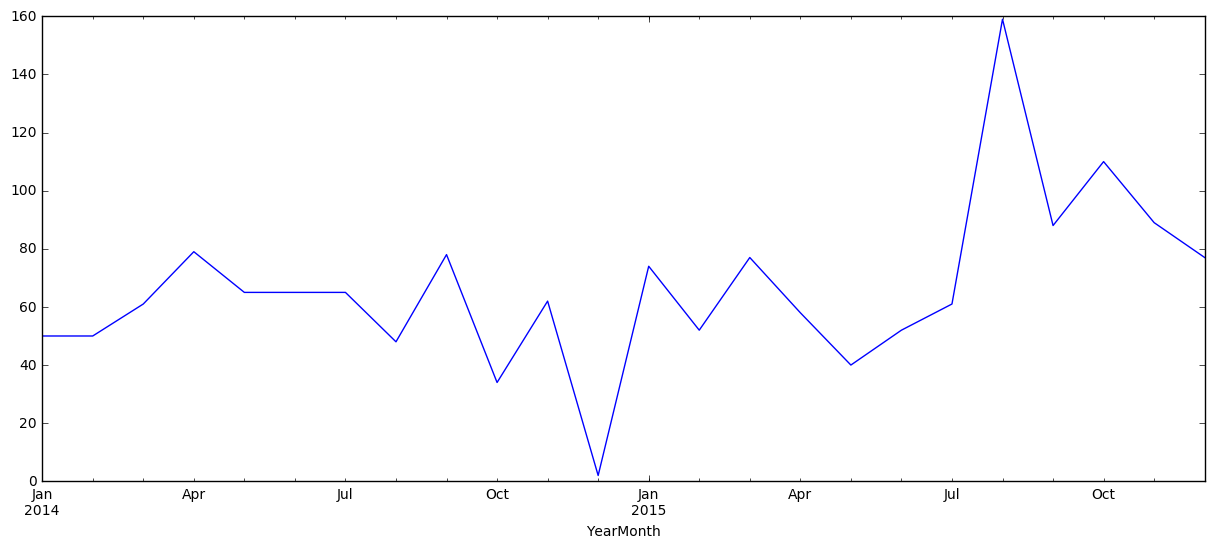

In [186]:
df_all.groupby('YearMonth')['id'].count().plot(figsize = (15,6))